In [1]:
import os
import cv2
import torch
from torchvision import transforms
from PIL import Image  # Import PIL for image conversion

# Define your images and masks directories
images_dir = "/Users/maryamrehmatulla/Desktop/images"
masks_dir = "/Users/maryamrehmatulla/Desktop/masks"  # Assuming masks are in the same directory

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to Tensor
    transforms.Resize((256, 256)),  # Resize images and masks to (256, 256)
])

def preprocess_data(images_dir, masks_dir, transform):
    images = []
    masks = []
    
    # Iterate through images in the directory
    for img_name in os.listdir(images_dir):
        if not img_name.endswith('.png'):  # Ensure only PNG files are processed
            continue
        
        img_path = os.path.join(images_dir, img_name)
        mask_path = os.path.join(masks_dir, img_name)  # Assuming mask names are the same as image names
        
        # Read images and masks
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read mask as grayscale
        
        # Check if images are loaded properly
        if img is None or mask is None:
            continue
        
        # Apply transformations
        img = transform(img)
        mask = transform(mask)
        
        # Append to lists
        images.append(img)
        masks.append(mask)
    
    return images, masks

# Preprocess data
images, masks = preprocess_data(images_dir, masks_dir, transform)

# Convert lists to PyTorch tensors
images_tensor = torch.stack(images)
masks_tensor = torch.stack(masks)

# Print shapes for verification
print(f"Images tensor shape: {images_tensor.shape}")
print(f"Masks tensor shape: {masks_tensor.shape}")


libpng error: Read Error
[ WARN:0@25.325] global loadsave.cpp:241 findDecoder imread_('/Users/maryamrehmatulla/Desktop/masks/clx3pk7il193907277eut0ch3.png'): can't open/read file: check file path/integrity
[ WARN:0@45.479] global loadsave.cpp:241 findDecoder imread_('/Users/maryamrehmatulla/Desktop/masks/clx3oto5m0yc80786qsy7y91p.png'): can't open/read file: check file path/integrity
[ WARN:0@79.945] global loadsave.cpp:241 findDecoder imread_('/Users/maryamrehmatulla/Desktop/masks/clx3oto5m0yce0786fj6ycmv0.png'): can't open/read file: check file path/integrity
[ WARN:0@90.015] global loadsave.cpp:241 findDecoder imread_('/Users/maryamrehmatulla/Desktop/masks/clx3oto5m0ybh0786y4w83yxp.png'): can't open/read file: check file path/integrity
[ WARN:0@98.033] global loadsave.cpp:241 findDecoder imread_('/Users/maryamrehmatulla/Desktop/masks/clx3nafw517kz0727kn6krqzc.png'): can't open/read file: check file path/integrity
libpng error: IDAT: CRC error
[ WARN:0@115.605] global loadsave.cpp:24

Images tensor shape: torch.Size([84, 3, 256, 256])
Masks tensor shape: torch.Size([84, 1, 256, 256])


Epoch 0/59
----------
LR 0.0001


/Users/maryamrehmatulla/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train: bce: 0.685334, dice: 0.990619, loss: 0.837976
val: bce: 0.675111, dice: 0.990094, loss: 0.832603
saving best model
1m 23s
Epoch 1/59
----------
LR 0.0001
train: bce: 0.668666, dice: 0.990571, loss: 0.829618
val: bce: 0.656102, dice: 0.990048, loss: 0.823075
saving best model
1m 25s
Epoch 2/59
----------
LR 0.0001
train: bce: 0.645809, dice: 0.990518, loss: 0.818163
val: bce: 0.625637, dice: 0.989988, loss: 0.807812
saving best model
1m 24s
Epoch 3/59
----------
LR 0.0001
train: bce: 0.607992, dice: 0.990454, loss: 0.799223
val: bce: 0.571054, dice: 0.989917, loss: 0.780485
saving best model
1m 26s
Epoch 4/59
----------
LR 0.0001
train: bce: 0.534483, dice: 0.990395, loss: 0.762439
val: bce: 0.449048, dice: 0.989965, loss: 0.719507
saving best model
1m 26s
Epoch 5/59
----------
LR 0.0001
train: bce: 0.336574, dice: 0.991055, loss: 0.663815
val: bce: 0.092028, dice: 0.995048, loss: 0.543538
saving best model
1m 26s
Epoch 6/59
----------
LR 0.0001
train: bce: 0.103769, dice: 0.9951

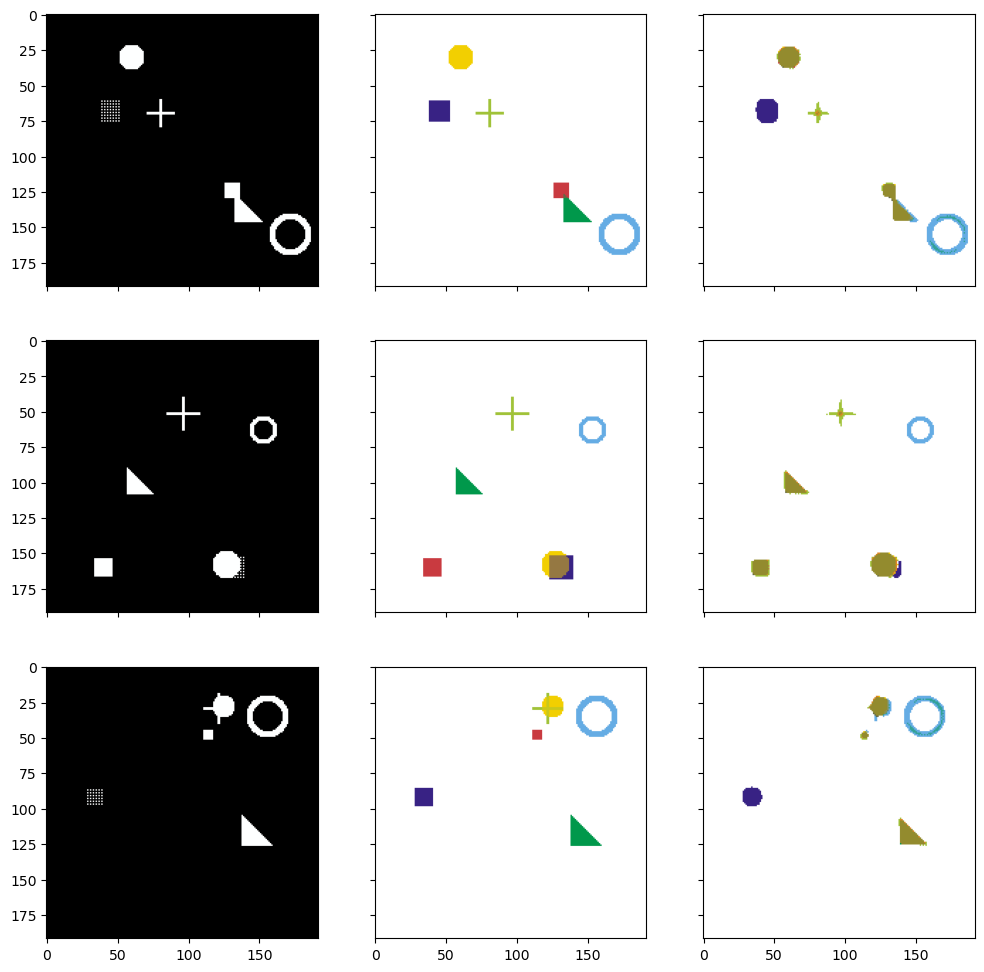

In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Assuming you have images_tensor and masks_tensor from your preprocessing step
dataset = TensorDataset(images_tensor, masks_tensor)
batch_size = 2  # Adjust batch size as needed
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

from Model import UNet  # Import your U-Net model

# Instantiate your U-Net model
model = UNet(n_class=1)  # Adjust n_class according to your task (e.g., number of classes for segmentation)

# Load model weights if needed
# model.load_state_dict(torch.load('path_to_your_model_weights.pth'))

model.eval()  # Set model to evaluation mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Choose device

predictions = []

# Iterate through the DataLoader for inference
with torch.no_grad():
    for images, masks in dataloader:
        images = images.to(device)
        
        # Perform inference
        outputs = model(images)
        
        # Assuming your model outputs logits, you might want to apply a sigmoid activation for probabilities
        # For example:
        # outputs = torch.sigmoid(outputs)
        
        # Append predictions (outputs) to the list
        predictions.append(outputs.cpu().detach())  # Detach and move to CPU if necessary

# Convert predictions list to a single tensor
predictions_tensor = torch.cat(predictions, dim=0)

# Print or process predictions as needed
print(f"Predictions tensor shape: {predictions_tensor.shape}")



In [7]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score

def calculate_metrics(predictions, targets, threshold=0.5):
    # Apply sigmoid to predictions and threshold to get binary masks
    predictions = torch.sigmoid(predictions)
    binary_predictions = (predictions > threshold).float()
    
    # Ensure targets are binary (0 or 1)
    binary_targets = (targets > threshold).float()
    
    # Flatten the tensors for metric calculation
    pred_flat = binary_predictions.view(-1).cpu().numpy()
    target_flat = binary_targets.view(-1).cpu().numpy()
    
    # Calculate accuracy
    accuracy = accuracy_score(target_flat, pred_flat)
    
    # Calculate precision
    precision = precision_score(target_flat, pred_flat)
    
    return accuracy, precision

# Assuming predictions_tensor contains your model's predictions
# and normalized_masks_tensor contains your ground truth masks
accuracies = []
precisions = []

for pred, target in zip(predictions_tensor, normalized_masks_tensor):
    acc, prec = calculate_metrics(pred, target)
    accuracies.append(acc)
    precisions.append(prec)

# Calculate average metrics
average_accuracy = sum(accuracies) / len(accuracies)
average_precision = sum(precisions) / len(precisions)

print(f"Average Accuracy: {average_accuracy:.4f}")
print(f"Average Precision: {average_precision:.4f}")


/Users/maryamrehmatulla/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average Accuracy: 0.9974
Average Precision: 0.0000
